# Mask R-CNN, resnet50 backbone with imagenet weights and training all layers

In [1]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import tensorflow
print(tensorflow.__version__)


1.15.2


In [3]:
# Installing the KERAS Specific version 2.0.8
#!pip install -q keras===2.0.8

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install pydicom

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install mlxtend  

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
#installing the MaskRCNN 
!pip install mrcnn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip3 install imgaug

You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
!pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
#Importing the Required Packages
import keras
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import io
import os
import pathlib
import glob
import time
from mrcnn.config import Config 
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize

from boto3 import client
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO


Using TensorFlow backend.


In [10]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'
dicom_images_path_filename = 'pneumonia-dataset/stage_2_images_path.csv'

In [12]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [13]:
# To Get the Coco Weights File one time
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [14]:
# Setting the Project Dir/DATA Dir/Out file directory in the project
#PROJ_DIR = "/content/gdrive/My Drive/Cap-project"
#DATA_DIR = os.path.abspath(PROJ_DIR +'/data')
#OUT_DIR = os.path.abspath(PROJ_DIR +'/out')
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(PROJ_DIR, 'logs')

#if not os.path.exists(PROJ_DIR):
#    os.makedirs(PROJ_DIR)
#os.chdir(PROJ_DIR)

In [15]:
def load_dicom_images_path(bkt , filename):

  print (' loading file name from  : ', bkt + '/' + filename)
  image_df = pd.DataFrame(columns=['path', 'patientId'])

  bucket = bkt
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  temp_df = pd.read_csv(data_location)
  
  i = 0  
  for ind in temp_df.index:
      dicom_folder_path = temp_df['path'][ind]
      dicom_image_filename = temp_df['filename'][ind]
      p_id = dicom_image_filename.split('.')[0]
      filepath = dicom_folder_path + dicom_image_filename
      image_df = image_df.append({'path': filepath, 'patientId': p_id}, ignore_index=True)
  
  return list(image_df.path)

In [16]:
# Functions to read the Dicom Directories and setting the annotations.
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(bkt, anns): 
    #image_fps = get_dicom_fps(dicom_dir)
    image_fps = load_dicom_images_path(bkt , dicom_images_path_filename)
     
    no_of_images = len(image_fps)
    image_annotations = {fp: [] for fp in image_fps}
   
    for index, row in anns.iterrows(): 
        #fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        fp = train_dicom_dir +  row['patientId']+'.dcm'
        image_annotations[fp].append(row)
    
    return image_fps, image_annotations

In [57]:
# Initialisation Config Files for the MASKRCNN 
class inputConfig():
    NUM_CLASSES = 2
    CLASS_DICT = {0: 'No Pneumonia', 1: 'Pneumonia with opacity'}
    CATEGORIES = list(CLASS_DICT.values())
    CATEGORIES_VALUES = list(CLASS_DICT.keys())

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    #RPN_ANCHOR_SCALES = (32, 64)   ## commented temporary
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100
    TOP_DOWN_PYRAMID_SIZE = 32
    #VALIDATION_STEPS = 1
    
    
config = DetectorConfig()
config.display()

# Initialisation and config Files for Transfer Learning using the coco Weights.
class DetectorConfig_tf(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia_tf'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (64, 128,192)
    RPN_NMS_THRESHOLD  = 0.9
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3 
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    STEPS_PER_EPOCH = 500 
    TRAIN_BN =True 

config_tf = DetectorConfig_tf()
config_tf.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

In [58]:
# Functions for read Dicom files and creating the annotations with patient id.
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    #------------------
    session = boto3.Session()
    s3_session = session.client('s3')
    #-------------------
    
    
    
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        #print('fp ', fp)
        
        fileobj = s3_session.get_object(Bucket=root_path,  Key=fp )
        # open the file object and read it into the variable dicom_data. 
        dicom_data = fileobj['Body'].read()
        # Read DICOM
        dicom_bytes = DicomBytesIO(dicom_data)
        c_dicom = dcmread(dicom_bytes)  
        image = c_dicom.pixel_array

        
        #ds = pydicom.read_file(fp)
        #image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        #print('image shape ', image.shape)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [42]:
# Reading the annotations from train labels file
#anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns = load_csv_file(root_path,train_lables_filename )
anns.head(6)
print(anns.shape)

(30227, 6)


In [21]:
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [22]:
# Parsing the datasets to get the annotions and images
#image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
image_fps, image_annotations = parse_dataset(root_path, anns=anns)

 loading file name from  :  sagemaker-capstone-pd/pneumonia-dataset/stage_2_images_path.csv


In [43]:
f = image_fps[0]
print(f)

pneumonia-dataset/stage_2_train_images/d0ef248f-6358-45d2-9264-79533aa50593.dcm


In [44]:
temp = image_annotations.get(f)
print(temp)

[patientId    d0ef248f-6358-45d2-9264-79533aa50593
x                                             298
y                                             216
width                                         260
height                                        511
Target                                          1
Name: 23197, dtype: object, patientId    d0ef248f-6358-45d2-9264-79533aa50593
x                                             602
y                                             284
width                                         253
height                                        371
Target                                          1
Name: 23198, dtype: object]


In [45]:
#i = 0
#for key, value in image_annotations.items():
#    print(key, ' : ', value)
#    i = i+1
#    if i == 10:
#        break

In [46]:
print(len (image_fps))
print(len (image_annotations))

26684
26684


In [47]:
# read dicom image from filepath 
session = boto3.Session()
s3_session = session.client('s3')

fileobj = s3_session.get_object(Bucket=root_path,  Key=image_fps[0] )
# open the file object and read it into the variable dicom_data. 
dicom_data = fileobj['Body'].read()

# Read DICOM
dicom_bytes = DicomBytesIO(dicom_data)
c_dicom = dcmread(dicom_bytes)  
c_dicom.pixel_array
#ds = pydicom.read_file(image_fps[0]) 
#image = ds.pixel_array # get image array

array([[  2,   3,   4, ...,  92, 109,  54],
       [  3,   4,   5, ..., 204, 209, 130],
       [  4,   5,   6, ..., 198, 202, 110],
       ...,
       [ 64, 113, 108, ..., 108, 105,  63],
       [ 72, 115, 106, ..., 107, 107,  72],
       [ 28,  63,  49, ...,  51,  59,  30]], dtype=uint8)

In [48]:
# Print the Dicom Parameters 
#ds
c_dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.27259.1517874477.475917
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'd0ef248f-6358-45d2-9264-79533aa50593'
(0010, 0020) Patient ID                          LO: 'd0ef248f-6358-45d2-9264-79533aa50593'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [49]:
ORIG_SIZE = 1024

In [50]:
#image_fps_list = list(image_fps[:100]) 
#image_fps_list = list(image_fps[:25000]) 
#####################################################################

image_fps_list = image_fps
# split dataset into training vs. validation dataset 
# split ratio is set to 0.8 vs. 0.2 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.2
split_index = int((1 - validation_split) * len(image_fps_list))

print('split_index ', split_index)

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))


split_index  21347
21347 5337


In [51]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [52]:
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    7d70f820-bae4-4369-88d6-26ae77141de5
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 12257, dtype: object]

In [53]:
# Preparing the Validation DataSet
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
pneumonia-dataset/stage_2_train_images/53553403-f449-4bf1-9d54-b76827ef7ffc.dcm
[0]


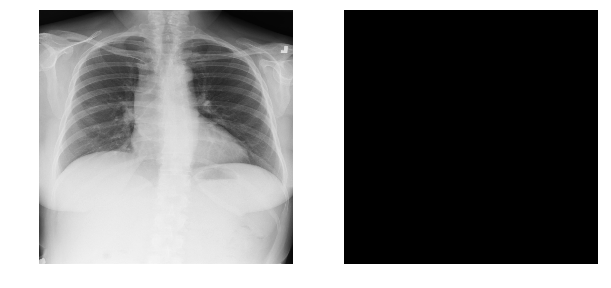

In [54]:

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)

image = dataset_train.load_image(image_id)

mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [59]:
#MODEL_DIR = os.path.join(PROJ_DIR, 'logs')
MODEL_DIR = '/home/ec2-user/SageMaker/logs'

In [60]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [61]:
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [62]:
epoch_time_start = time.time()
print ('epoch_time_start :', epoch_time_start)

epoch_time_start : 1590569689.2124674


In [63]:
NUM_EPOCHS = 5
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all'
            ,augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ec2-user/SageMaker/logs/pneumonia20200527T0854/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [44]:
epoch_end_time = time.time() - epoch_time_start
print ('epoch_time_end :', time.time())
print ('Time taken :', epoch_end_time)

epoch_time_end : 1590526206.05938
Time taken : 3476.123186349869


In [64]:
#Getting the Latest model File
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
print(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

['pneumonia20200526T1748', 'pneumonia20200526T1823', 'pneumonia20200526T1922', 'pneumonia20200526T1939', 'pneumonia20200526T1951', 'pneumonia20200526T2050', 'pneumonia20200527T0759', 'pneumonia20200527T0834', 'pneumonia20200527T0854', 'pneumonia20200527T0937']
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200526T1748
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200526T1922
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200526T1939
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200526T2050
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200527T0759
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200527T0834
No weight files in /home/ec2-user/SageMaker/logs/pneumonia20200527T0937
Found model /home/ec2-user/SageMaker/logs/pneumonia20200527T0854/mask_rcnn_pneumonia_0004.h5
